In [1]:
import os
os.environ['OMP_NUM_THREADS']="1"
from firedrake import *
from firedrake.__future__ import Interpolator
from firedrake.pyplot import triplot
import math
import operator
from mpi4py import MPI

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny)

In [3]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

z_test = TestFunction(Z)
u_test, p_test = split(z_test)
q_test = TestFunction(Q)

z_trial = TrialFunction(Z)
u_trial, p_trial = split(z_trial)
q_trial = TrialFunction(Q)

norm = FacetNormal(mesh)

dx = Measure("dx", domain=mesh)
ds = Measure("ds", domain=mesh)
dS = Measure("dS", domain=mesh)

X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
T.interpolate((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1])))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f509b3e86e0>, FiniteElement('Lagrange', triangle, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 8)

In [4]:
gamma_T, gamma_Z = Constant(ln(10**5)), Constant(ln(10))  # temperature and depth sensitivity of viscosity
mu_star, sigma_y = Constant(0.001), Constant(1.0)
epsilon = sym(grad(u))  # Strain-rate
epsii = sqrt(inner(epsilon, epsilon) + 1e-10)  # 2nd invariant (with tolerance to ensure stability)
mu_lin = exp(-gamma_T*T + gamma_Z*(1 - X[1]))  # linear component of rheological formulation
mu_plast = mu_star + (sigma_y / epsii)  # plastic component of rheological formulation
mu = (2. * mu_lin * mu_plast) / (mu_lin + mu_plast)  # harmonic mean

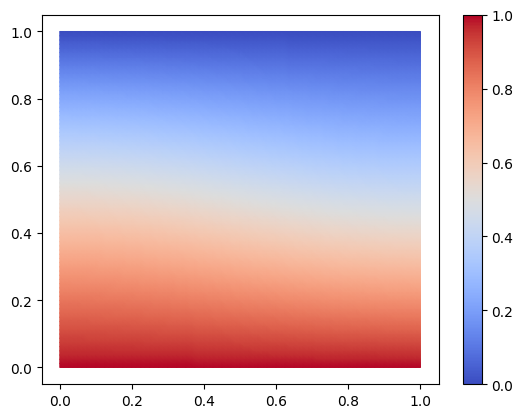

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

## Time stepping

In [6]:

Ra = Constant(100)  # Rayleigh number

time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.
### t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
ref_vel_interpolator = Interpolator(abs(dot(JacobianInverse(mesh), u)), V, access=op2.MAX)

def compute_timestep(dt_const):
    maximum_timestep = 0.1
    increase_tolerance = 1.5
    max_ts = float(dt_const)*increase_tolerance
    max_ts = min(max_ts, maximum_timestep)
    # need to reset ref_vel to avoid taking max with previous values
    ref_vel = assemble(ref_vel_interpolator.interpolate())
    local_maxrefvel = ref_vel.dat.data.max()
    max_refvel = mesh.comm.allreduce(local_maxrefvel, MPI.MAX)
    # NOTE; we're incorparating max_ts here before dividing by max. ref. vel. as it may be zero
    ts = 1.0 / max(max_refvel, 1.0 / max_ts)
    return ts

## Null spaces

In [7]:
### closed=True, rotational=False
stokes_subspaces = Z.subspaces
V_nullspace = stokes_subspaces[0]
p_nullspace = VectorSpaceBasis(constant=True,comm=Z.mesh().comm)
Z_nullspace = MixedVectorSpaceBasis(Z,[V_nullspace, p_nullspace])

## Energy solver setup

In [8]:
direct_energy_solver_parameters= {
    "mat_type": "aij",
    "snes_type": "ksponly",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_monitor": None,
}

In [9]:
### Energy solver

###    terms_mapping = {
###        "advection": scalar_eq.advection_term,
###        "diffusion": scalar_eq.diffusion_term,
###        "sink": scalar_eq.sink_term,
###        "source": scalar_eq.source_term,
###    }
###
###    def energy_source(self, u):
###        return self.rho * self.H
###    def linearized_energy_sink(self, u):
###        return 0
### BoussinesqApproximation - rho = 1, H = 0
###            "sink_coeff": self.approximation.linearized_energy_sink(self.u),
###            "source": self.approximation.energy_source(self.u),
###            

def F_advection(test, trial, u, n, dx, ds):
    return trial * div(test * u) * dx - trial * dot(n,u) * test * ds
    #return 0

def F_diffusion(test, trial, dx):
    return -( inner(grad(test),grad(trial)) * dx )
    #return 0

def F_mass( test, trial, dx ):
    return dot(test,trial) * dx

### Time stepping
a = np.array([[0.5]])
b = np.array([1.0])
c = np.array([0.5])
T_old = Function(T)
energy_bcs = [ DirichletBC(Q,0.0,4), DirichletBC(Q,1.0,3) ]
quad_degree = 5
hom_bcs = [bci.__class__(bci.function_space(), 0, bci.sub_domain) for bci in energy_bcs]

tendency = Function(Q) ### k[0]
u_inner = T_old + 0.5*delta_t*tendency
F_energy = F_mass(q_test,tendency,dx) - ( F_advection(q_test,u_inner,u,norm,dx,ds) + F_diffusion(q_test,u_inner,dx))
energy_problem = NonlinearVariationalProblem(F_energy,tendency,bcs=hom_bcs)
energy_solver = NonlinearVariationalSolver(energy_problem, solver_parameters=direct_energy_solver_parameters)
sol_expr = tendency * 0.5*delta_t
final_sol_expr = T_old + tendency * delta_t

In [10]:
u

ListTensor(Indexed(Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f509b3e86e0>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f509b3e86e0>, FiniteElement('Lagrange', triangle, 1), name=None, index=1, component=None), name='None_None'), MeshSequence((Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)))), 2), MultiIndex((FixedIndex(0),))), Indexed(Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f509b3e86e0>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f509b3e86e0>, FiniteElement('Lagrange', triangle, 1), name=None, index=1, component

## Stokes solver setup

In [11]:
stokes_solver_parameters = {"snes_type": "ksponly",
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
#    "snes_monitor": None,
}

In [12]:
### Stokes Solver
### linear = True
stokes_bcs = [ DirichletBC(Z.sub(0).sub(0), 0.0, 1), DirichletBC(Z.sub(0).sub(0), 0.0, 2), DirichletBC(Z.sub(0).sub(1), 0.0, 3), DirichletBC(Z.sub(0).sub(1), 0.0, 4) ]

stress = 2 * mu * sym(grad(u))
### buoyancy = self.Ra * self.rho * self.alpha * (T - self.T0) * self.g - self.RaB * self.delta_rho * self.g
### source = buoyancy * k
source = ( Ra * T ) * as_vector([0,1])

def F_viscosity(test,stress,dx):
    return -( inner(nabla_grad(test),stress ) * dx )

def F_pressure_gradient(test, p, dx):
    return dot(div(test),p) * dx

def F_divergence(test, u, dx):
    return dot(test, div(u)) * dx

def F_momentum_source(test,source,dx):
    return dot(test,source) * dx

F_stokes = -F_momentum_source(u_test,source,dx) - F_pressure_gradient(u_test,p,dx) - F_viscosity(u_test,stress,dx) - F_divergence(p_test,u,dx)

stokes_problem = NonlinearVariationalProblem(F_stokes,z,bcs=stokes_bcs)
stokes_solver = NonlinearVariationalSolver(stokes_problem,solver_parameters=stokes_solver_parameters,nullspace=Z_nullspace,transpose_nullspace=Z_nullspace)

### setup solver
#F_stokes_lin = replace(F_stokes,{z:z_trial})
#a, L = lhs(F_stokes_lin), rhs(F_stokes_lin)

#stokes_problem = LinearVariationalProblem(a,L,z,stokes_bcs,constant_jacobian=True)
#stokes_solver = LinearVariationalSolver(stokes_problem,solver_parameters=stokes_solver_parameters,nullspace=Z_nullspace,transpose_nullspace=Z_nullspace)

In [13]:
for timestep in range(0,timesteps):

    delta_t.assign(compute_timestep(delta_t))
    print(float(delta_t))
    
    stokes_solver.solve()

    for bci in energy_bcs:
        bci.apply(T)
    T_old.assign(T)
    energy_solver.solve()
    T.assign(T_old + sol_expr)
    T.assign(final_sol_expr)

    maxchange = sqrt(assemble((T - T_old)**2 * dx))
    if maxchange < steady_state_tolerance:
        print("Done?")
        break
    #if timestep == 10:
    #    break

1.5e-06
  0 SNES Function norm 1.994461909894e-02
  1 SNES Function norm 7.675416573099e-16
2.25e-06
  0 SNES Function norm 4.356454724785e-03
  1 SNES Function norm 7.741696291494e-16
3.375e-06
  0 SNES Function norm 7.831388038822e-04
  1 SNES Function norm 8.341246804771e-16
5.062499999999999e-06
  0 SNES Function norm 7.937651090122e-05
  1 SNES Function norm 8.497648156387e-16
7.593749999999999e-06
  0 SNES Function norm 1.438562281740e-05
  1 SNES Function norm 8.589855589277e-16
1.1390624999999999e-05
  0 SNES Function norm 2.040801542308e-05
  1 SNES Function norm 8.663338573048e-16
1.7085937499999998e-05
  0 SNES Function norm 3.035698195341e-05
  1 SNES Function norm 8.736664952889e-16
2.5628906249999997e-05
  0 SNES Function norm 4.545368640377e-05
  1 SNES Function norm 8.255920322928e-16
3.8443359375e-05
  0 SNES Function norm 6.829254337600e-05
  1 SNES Function norm 8.510424613828e-16
5.766503906249999e-05
  0 SNES Function norm 1.028203471641e-04
  1 SNES Function norm 

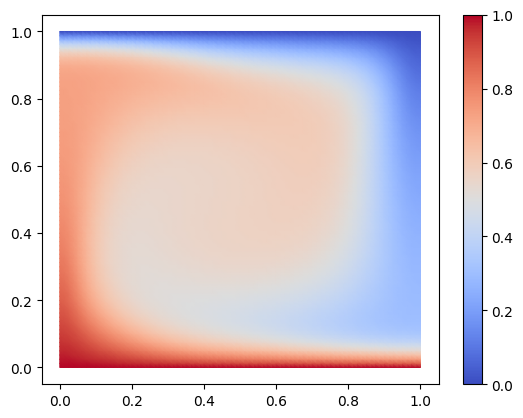

In [14]:
fig, axes = plt.subplots()
collection = tripcolor(assemble(T), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

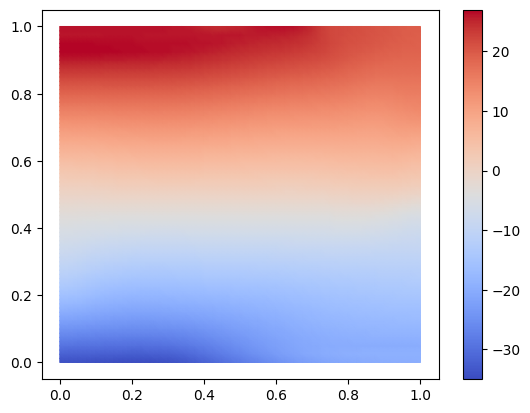

In [15]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(1), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

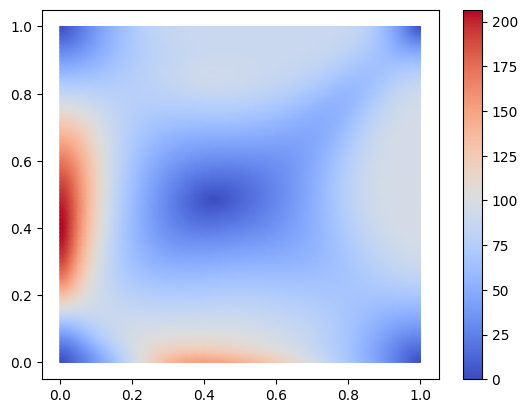

In [16]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(0), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

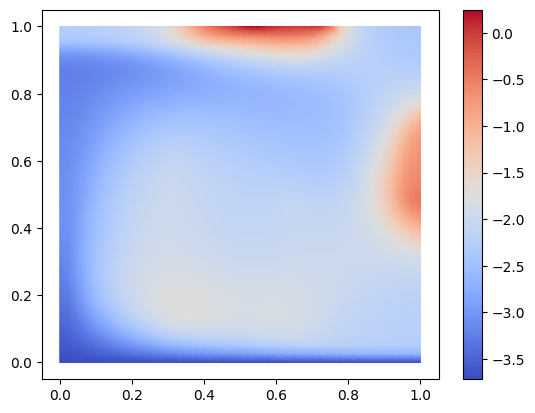

In [17]:
fig, axes = plt.subplots()
mu_field = Function(W, name="Viscosity")
mu_field.interpolate(ln(mu) / ln(10))
collection = tripcolor(mu_field, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

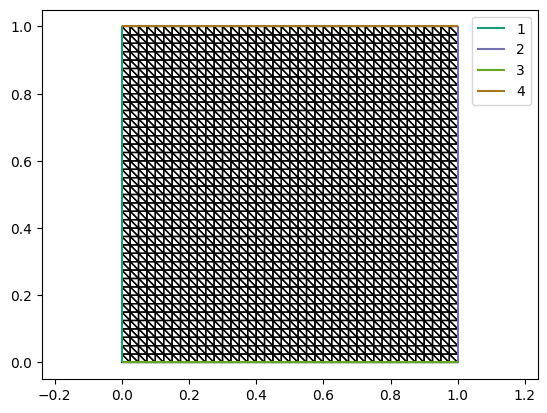

In [18]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh, axes=axes)
axes.legend()